In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pianoq.simulations.mplc_sim.mplc_sim import MPLCSim
from pianoq.simulations.mplc_sim.mplc_modes2 import gen_input_spots_array, gen_output_modes_Unitary

can't use vimba camera
can't import TimeTagger
could not import ThorlabsRotatingServoMotor


## Run MPLC to generate QKD masks like Ohad

### Parameters

In [10]:
# All in m

# dist_after_plane[i] is distance between planes i and i+1 (counting from 0)
dist_after_plane = 87e-3*np.ones(10)
dist_after_plane[4] = 138e-3
active_planes = np.array([True] * 11)

waist_in = 80e-6
waist_out = 45e-6
D_between_modes_in = 300e-6
D_between_modes_out = 360e-6

dim=5
which_modes = np.array([ 2,  7, 12, 17, 22, 
                        27, 32, 37, 42, 47])

#  Based on "All Mutually Unbiased Bases in Dimensions Two to Five" (2018)
#  The columns in the matrix are the basis elements
q = np.exp(2j * np.pi / 5)  # Complex fifth root of unity
MUB = np.array([
    [1, 1, 1, 1, 1],
    [1, q, q**2, q**3, q**4],
    [1, q**2, q**4, q, q**3],
    [1, q**3, q, q**4, q**2],
    [1, q**4, q**3, q**2, q]
]) / np.sqrt(5)  # eq. 33

Matrix_trans1 = MUB.conj().T  # To measure in X basis, we need to act with X^dag on the state
zeros_mat = np.zeros((5, 5))
full_transformation = np.block([[Matrix_trans1, zeros_mat],
                                [zeros_mat, np.conj(Matrix_trans1)]])  # [DFT,0; 0, iDFT] final matrix. the conj in bottom right is for correlation to be on identity

N_modes = 10
# All in mm
conf = {'wavelength': 810e-9,  # mm
        'dist_after_plane': dist_after_plane,  # mm
        'active_planes': active_planes,  # bool
        'N_iterations': 30,
        'Nx': 140,  # Number of grid points x-axis
        'Ny': 360,  # Number of grid points y-axis
        'dx': 12.5e-6,  # mm - SLM pixel sizes
        'dy': 12.5e-6,  # mm
        'max_k_constraint': 0.15,  # Ohad: better than 0.1 or 0.2, but not very fine-tuned
        'N_modes': N_modes,
        'min_log_level': 2,
        'size_factor': 3,  # assumed to be odd. Have physical larger grid than the actual SLM planes
        'use_mask_offset': True,
        'symmetric_masks': False
        }


In [11]:
mplc = MPLCSim(conf=conf)
# input_modes = get_spots_modes_conf(conf, sig=0.1, N_rows=N_N_modes, N_cols=N_N_modes, spacing=0.6)
input_spots, x_modes_in, y_modes_in = gen_input_spots_array(waist=waist_in, D_between_modes=D_between_modes_in, XX=mplc.XX, YY=mplc.YY, dim=dim)
input_modes = input_spots[which_modes]
x_modes_in = x_modes_in[which_modes]
y_modes_in = y_modes_in[which_modes]

output_modes, phase_pos_x, phase_pos_y = gen_output_modes_Unitary(waist_out, D_between_modes_out, mplc.XX, mplc.YY, full_transformation, dim, which_modes)

In [12]:
mplc.set_modes(input_modes, output_modes)
mplc.find_phases(iterations=5, fix_initial_phases=True)

  0%|          | 0/5 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [8]:
mplc.fix_initial_phases()

In [ ]:
mplc.res._calc_normalized_overlap()
display(np.angle(np.diag(mplc.res.forward_overlap)))
display(np.abs(np.diag(mplc.res.forward_overlap)))
# display(np.diag(mplc.res.forward_overlap))
mplc.res._calc_fidelity()
display(mplc.res.fidelity)
# mplc.res.show_overlap()

In [ ]:
input_spots, x_modes_in, y_modes_in = gen_input_spots_array(waist=waist_in, D_between_modes=D_between_modes_in, XX=mplc.XX, YY=mplc.YY, dim=dim)
fig, ax = plt.subplots()
ax.imshow((np.abs(input_spots.sum(axis=0))**2))

In [5]:
path = r'G:\My Drive\People\Ronen\PHD\MPLC\results\2024_11_08_13_11_11_QKD_row3\mrss_wfm.masks'
mplc.res.save_masks(path)

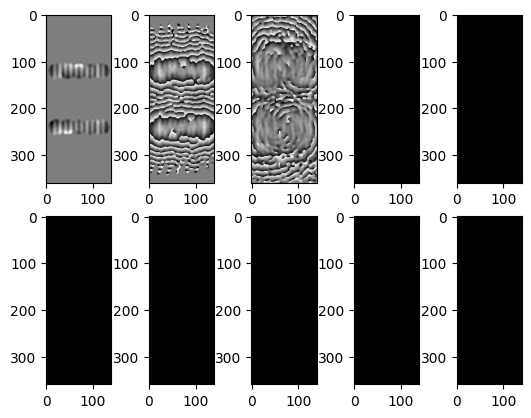

In [13]:
fig, axes = plt.subplots(2, 5)
for i, ax in enumerate(axes.flat):
    # ax.imshow(np.angle(res.masks[i][360:720, 140:280]), cmap='gray')
    ax.imshow(np.angle(mplc.res.masks[i][360:720, 140:280]), cmap='gray')

In [5]:
mplc.res.saveto("C:\\temp\\QKD1.mplc", smaller=True)

In [19]:
from pianoq.simulations.mplc_sim.mplc_sim_result import MPLCSimResult
res = MPLCSimResult()
res.loadfrom("C:\\temp\\QKD1.mplc")

C:\code\pianoq\pianoq\simulations\mplc_sim\mplc_sim_result.py:156: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


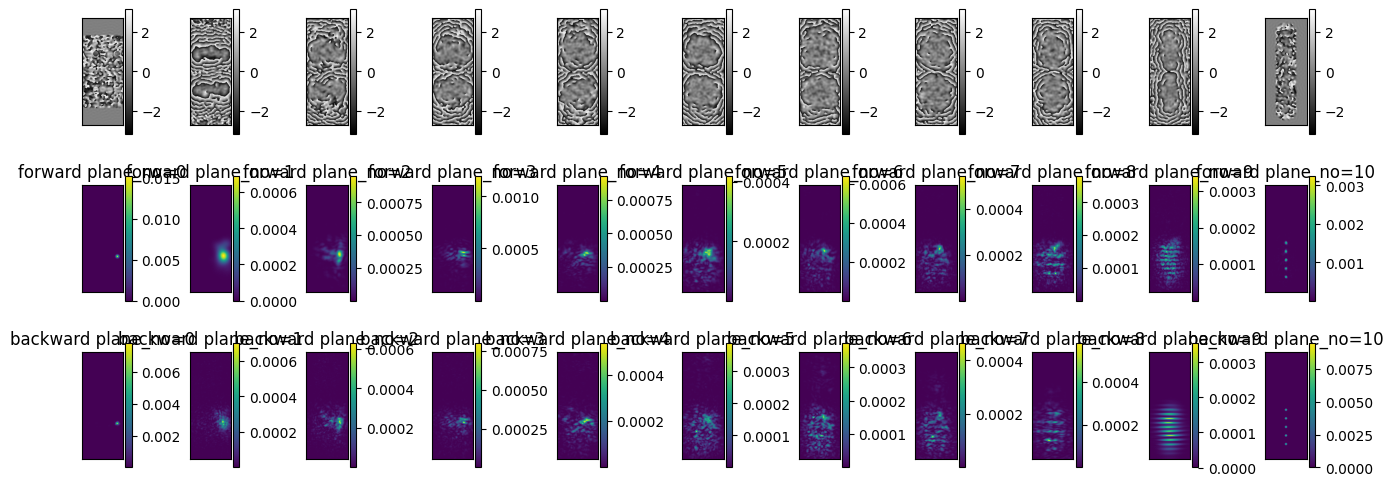

In [11]:
mplc.res.show_all(0)

### test against matlab modes

In [20]:
from pianoq.misc.mplt import *
import scipy.io
data = scipy.io.loadmat(r"G:\My Drive\Ohad and Giora\MPLC\matlab codes\Ronen stuff 17.7.24\WFM stuff\Masks_31_10_23_QKD5d_MUB2_mm_33_3_conjbases.mat")
in_modes_matlab = data['SPOTS']
out_modes_matlab = data['MODES']
flag = False
if flag:
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(np.abs(in_modes_matlab[0])**2)
    axes[1].imshow(np.abs(input_modes[0])**2)
    axes[2].imshow(np.abs(input_modes[0] - in_modes_matlab[0])**2)
# mimshow(in_modes_matlab[0] == input_modes[0])
np.abs(out_modes_matlab - output_modes).sum() # is ~1e-13 which means it is only floating point issues

display((data['X'] - mplc.XX).max())  # again not idenical, but the same up to rounding errors
display(mplc.XX[0,0], mplc.XX[-1, -1])

In [17]:
data = scipy.io.loadmat(r"G:\My Drive\Ohad and Giora\MPLC\matlab codes\Ronen stuff 17.7.24\WFM stuff\k_space_vars.mat")
fig, axes = plt.subplots(1, 3)
axes[0].imshow(data['k_constraint'])
axes[1].imshow(mplc.k_constraint)
axes[2].imshow(mplc.k_constraint - data['k_constraint'])
# ax.plot(range(len(mplc.freq_y)), data['v_y'].squeeze(), '.')
# ax.plot(range(len(mplc.freq_y)), mplc.freq_y, '.')
# ax.plot(data['v_y'].squeeze() - mplc.freq_y)
# print(data['v_y'].squeeze()[0])
# print(mplc.freq_y[0])


In [12]:
data = scipy.io.loadmat(r"G:\My Drive\Ohad and Giora\MPLC\matlab codes\Ronen stuff 17.7.24\WFM stuff\freespace.mat")
H_mat = data['H']
H_py = np.exp(+1j * mplc.k_z_mat * 87e-3)

fig, axes = plt.subplots(1, 3)
imm = axes[0].imshow(np.angle(H_mat))
fig.colorbar(imm, ax=axes[0])
imm = axes[1].imshow(np.angle(H_py))
fig.colorbar(imm, ax=axes[1])
imm = axes[2].imshow(np.angle(H_py) - np.angle(H_mat))
fig.colorbar(imm, ax=axes[2])

In [18]:
mplc.res.active_slice

In [12]:
mat_masks = scipy.io.loadmat(r"G:\My Drive\Ohad and Giora\MPLC\matlab codes\Ronen stuff 17.7.24\WFM stuff\Masks_31_10_23_QKD5d_MUB2_mm_33_3_conjbases.mat")['MASKS'][:, 360:720, 140:280]
py_masks = mplc.res.masks[:, 360:720, 140:280]
mat_masks = np.angle(mat_masks)
py_masks = np.angle(py_masks)

In [18]:
i = 0
fig, axes = plt.subplots(1, 3)
axes[0].imshow(mat_masks[i], cmap='gray')
axes[0].set_title('matlab')
axes[1].imshow(py_masks[i], cmap='gray')
axes[1].set_title('python')
axes[2].imshow(mat_masks[i] - py_masks[i], cmap='gray')
axes[2].set_title('diff')

# Use new function to do the WFM, and then just display some metrics

In [ ]:
from pianoq.simulations.mplc_sim.create_wfm_masks import create_WFM_QKD_masks

mplc = create_WFM_QKD_masks(N_iterations=2)

 50%|█████     | 1/2 [00:10<00:10, 10.84s/it]

In [ ]:
mplc.res._calc_normalized_overlap()
display(np.angle(np.diag(mplc.res.forward_overlap)))
display(np.diag(mplc.res.forward_overlap))
mplc.res._calc_fidelity()
display(mplc.res.fidelity)

C:\code\pianoq\pianoq\simulations\mplc_sim\mplc_sim_result.py:95: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


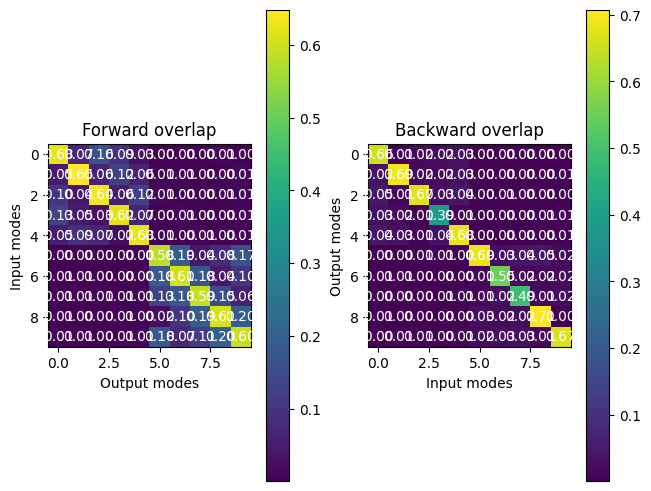

In [9]:
mplc.res.show_overlap()

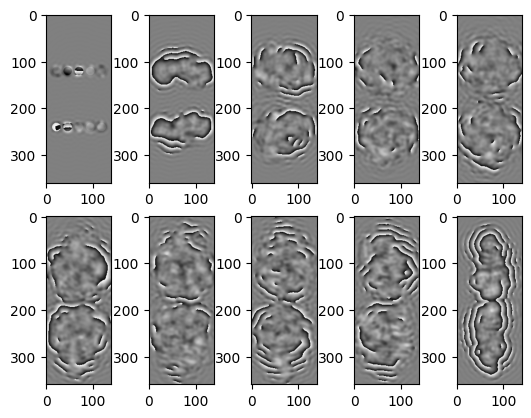

In [10]:
fig, axes = plt.subplots(2, 5)
for i, ax in enumerate(axes.flat):
    # ax.imshow(np.angle(res.masks[i][360:720, 140:280]), cmap='gray')
    ax.imshow(np.angle(mplc.res.masks[i][360:720, 140:280]), cmap='gray')

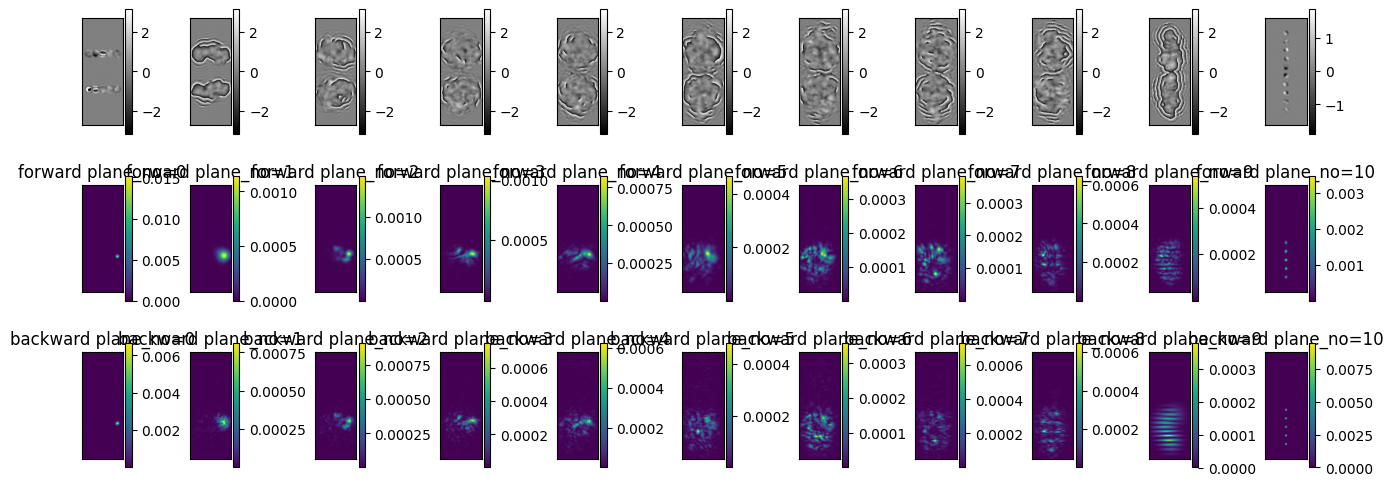

In [12]:
mplc.res.show_all()